# Importing

In [1]:
import sys
sys.executable

'/home/sarah/Documentos/PSGCode/psg-venv/bin/python'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
from geexhp import datasetup as dset

import tensorflow as tf
from geexhp import cnn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import corner
import matplotlib.pyplot as plt
from PIL import ImageFont
from tensorflow.keras.utils import plot_model # type: ignore
import visualkeras
from geexhp import datavis
datavis.configure_matplotlib()


# Data Setup

In [4]:
#folder = "../parallel/data/"
#df = dset.combine_parquet(folder=folder, keyword="_", output_file=True)

In [5]:
df = pd.read_parquet("../data/__data.parquet")

In [6]:
dfabun = dset.extract_abundances(df)
dfabun.dropna(inplace=True)

# Preprocessing data and creating the training and testing datasets

In [7]:
# Define inputs and outputs
inputs = 'ALBEDO'
outputs_list = ['OBJECT-DIAMETER', 'OBJECT-GRAVITY', 'ATMOSPHERE-PRESSURE', 'ATMOSPHERE-TEMPERATURE',
                'C2H6', 'CH4', 'CO', 'CO2', 'H2', 'H2O', 'HCN', 'N2',
                'N2O', 'NH3', 'O2', 'O3', 'PH3']

# 2. Split the Data
# Prepare inputs
X = np.stack(dfabun[inputs].values)
# Prepare outputs
y = dfabun[outputs_list].copy()

# Extract stratification labels
stratify_labels = dfabun["Earth_type"]

In [8]:
# Initial train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=dfabun["Earth_type"])

# Get the indices of the training data
train_indices = y_train.index

# Get stratify labels for training data
stratify_train_labels = dfabun.loc[train_indices, "Earth_type"]

# Perform train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=stratify_train_labels)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(25440, 2304)
(6360, 2304)
(7951, 2304)


In [10]:
# 3. Normalize the Data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

num_features = len(outputs_list)
y_scalers = []
y_train_scaled = np.zeros_like(y_train)
y_val_scaled = np.zeros_like(y_val)
y_test_scaled = np.zeros_like(y_test)

for i in range(num_features):
    scaler = StandardScaler()
    y_train_scaled[:, i] = scaler.fit_transform(y_train.to_numpy()[:, i].reshape(-1, 1)).ravel()
    y_val_scaled[:, i] = scaler.transform(y_val.to_numpy()[:, i].reshape(-1, 1)).ravel()
    y_test_scaled[:, i] = scaler.transform(y_test.to_numpy()[:, i].reshape(-1, 1)).ravel()
    y_scalers.append(scaler)

In [11]:
# 6. Reshape inputs for CNN
X_train_scaled = X_train_scaled[..., np.newaxis]
X_val_scaled = X_val_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]

input_shape = X_train_scaled.shape[1:]  # (sequence_length, 1)
output_units = y_train_scaled.shape[1]  # Number of outputs

In [12]:
X_train_scaled.shape

(25440, 2304, 1)

In [13]:
y_train_dict = {output_name: y_train_scaled[:, idx] for idx, output_name in enumerate(outputs_list)}
y_val_dict = {output_name: y_val_scaled[:, idx] for idx, output_name in enumerate(outputs_list)}
y_test_dict = {output_name: y_test_scaled[:, idx] for idx, output_name in enumerate(outputs_list)}

In [14]:
batch_size = 32

def _parse_function(x, y):
    x = tf.cast(x, tf.float32)
    y = {key: tf.cast(value, tf.float32) for key, value in y.items()}
    return x, y

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_dict))
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val_dict))
validation_dataset = validation_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_dict))
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Convolutional Neural Network 1D (CNN) with tuning hyperparameters

In [15]:
# Instantiate the HyperTuningBayCNN class
cnn_tuner = cnn.HyperTuningBayCNN(input_shape, output_units, outputs_list)

In [14]:
# Perform hyperparameter search
best_hps = cnn_tuner.search(train_dataset, validation_dataset, max_trials=40, search_epochs=2)

Trial 40 Complete [00h 11m 59s]
val_loss: 13.226622581481934

Best val_loss So Far: 6.380260467529297
Total elapsed time: 09h 26m 46s


In [15]:
# Fit the best model
best_model, history = cnn_tuner.fit_best_model(train_dataset, validation_dataset, epochs=100, patience=8)

Epoch 1/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 1137s 1s/step - ATMOSPHERE-PRESSURE_loss: 0.9678 - ATMOSPHERE-TEMPERATURE_loss: 0.9094 - C2H6_loss: 1.2519 - CH4_loss: 0.7061 - CO2_loss: 0.8883 - CO_loss: 1.1666 - H2O_loss: 0.8828 - H2_loss: 1.0363 - HCN_loss: 0.7775 - N2O_loss: 0.5936 - N2_loss: 0.5759 - NH3_loss: 0.8665 - O2_loss: 1.0098 - O3_loss: 1.8311 - OBJECT-DIAMETER_loss: 1.0242 - OBJECT-GRAVITY_loss: 0.9906 - PH3_loss: 0.8641 - loss: 16.3631 - val_ATMOSPHERE-PRESSURE_loss: 0.3204 - val_ATMOSPHERE-TEMPERATURE_loss: 0.2909 - val_C2H6_loss: 0.9948 - val_CH4_loss: 0.1701 - val_CO2_loss: 0.3214 - val_CO_loss: 0.5118 - val_H2O_loss: 0.2642 - val_H2_loss: 0.6214 - val_HCN_loss: 0.2160 - val_N2O_loss: 0.3117 - val_N2_loss: 0.1677 - val_NH3_loss: 0.5107 - val_O2_loss: 0.2466 - val_O3_loss: 1.7660 - val_OBJECT-DIAMETER_loss: 0.3186 - val_OBJECT-GRAVITY_loss: 0.3199 - val_PH3_loss: 0.3643 - val_loss: 7.7427
Epoch 2/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 1134s 1s/step - ATMOSPHERE-PRESSURE_loss: 0.234

In [16]:
cnn_tuner.save("../models/model.keras")

Model saved at model.keras


In [28]:
cnn_tuner.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2304, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 2300, 128) │        768 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 2296, 128) │     82,048 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1148, 128) │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1148, 128) │        512 │ max_pooling1d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_4        │ (None, 1148, 128) │          0 │ batch_normalizat… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 146944)    │          0 │ mc_dropout_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 448)       │ 65,831,360 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_5        │ (None, 448)       │          0 │ dense_1[0][0]     │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    114,944 │ mc_dropout_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_6        │ (None, 256)       │          0 │ dense_2[0][0]     │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    131,584 │ mc_dropout_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_7        │ (None, 512)       │          0 │ dense_3[0][0]     │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ATMOSPHERE-PRESSURE │ (None, 1)         │        513 │ mc_dropout_7[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ATMOSPHERE-TEMPERA… │ (None, 1)         │        513 │ mc_dropout_7[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C2H6 (Dense)        │ (None, 1)         │        513 │ mc_dropout_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CH4 (Dense)         │ (None, 1)         │        513 │ mc_dropout_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CO (Dense)          │ (None, 1)         │        513 │ mc_dropout_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CO2 (Dense)         │ (None, 1)         │        513 │ mc_dropout_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ H2 (Dense)          │ (None, 1)         │        513 │ mc_dropout_7[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 198,509,300 (757.25 MB)

 Trainable params: 66,169,681 (252.42 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 132,339,363 (504.83 MB)

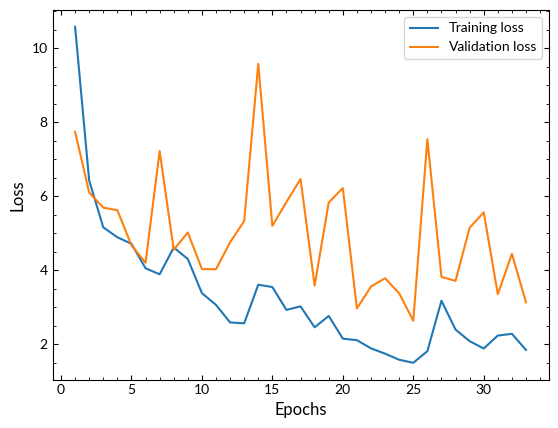

In [29]:
cnn_tuner.plot_losses()

In [16]:
cnn_tuner.load_model("../models/model.keras")

Model loaded from ../models/model.keras


Saving figure in ../images/


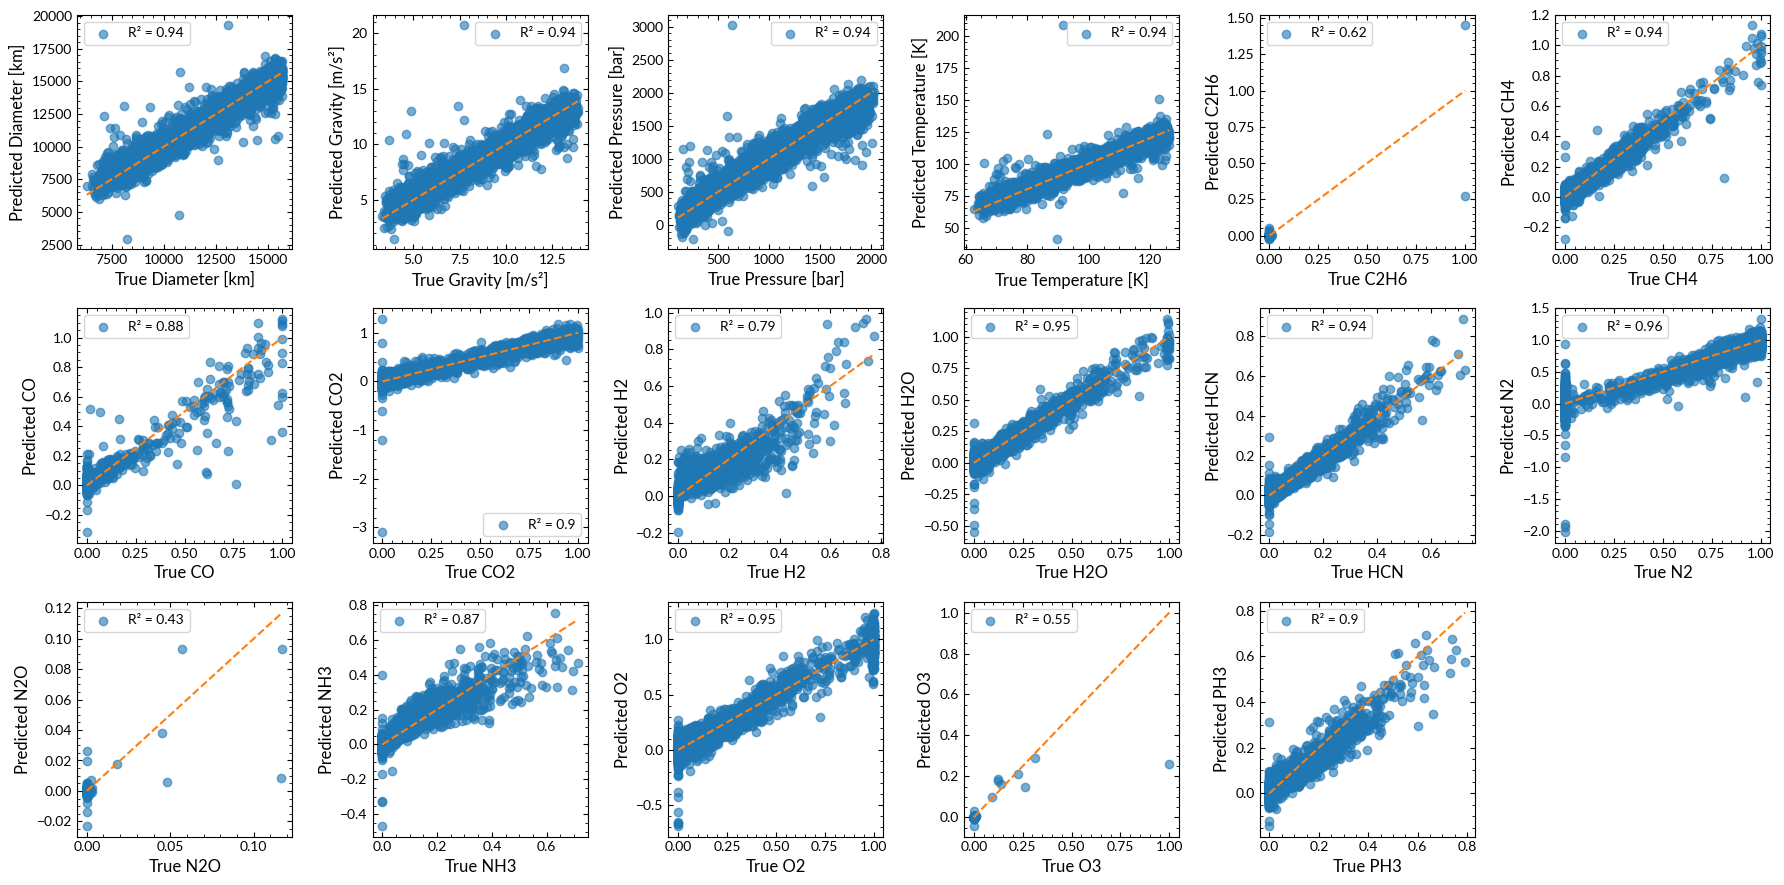

In [17]:
names = ['Diameter [km]', 'Gravity [m/s²]', 'Pressure [bar]', 'Temperature [K]',
         'C2H6', 'CH4', 'CO', 'CO2', 'H2', 'H2O', 'HCN', 'N2', 'N2O', 'NH3', 'O2', 'O3', 'PH3']

results = cnn_tuner.evaluate(test_dataset, names, y_scalers, plot=True)

In [18]:
results

,R² scores,MAE scores,RMSE scores
Diameter [km],0.94,386.029999,547.640015
Gravity [m/s²],0.94,0.450000,0.650000
Pressure [bar],0.94,83.669998,119.860001
Temperature [K],0.94,2.720000,4.010000
C2H6,0.62,0.000000,0.010000
CH4,0.94,0.020000,0.030000
CO,0.88,0.010000,0.030000
CO2,0.90,0.040000,0.070000
H2,0.79,0.020000,0.040000
H2O,0.95,0.020000,0.030000


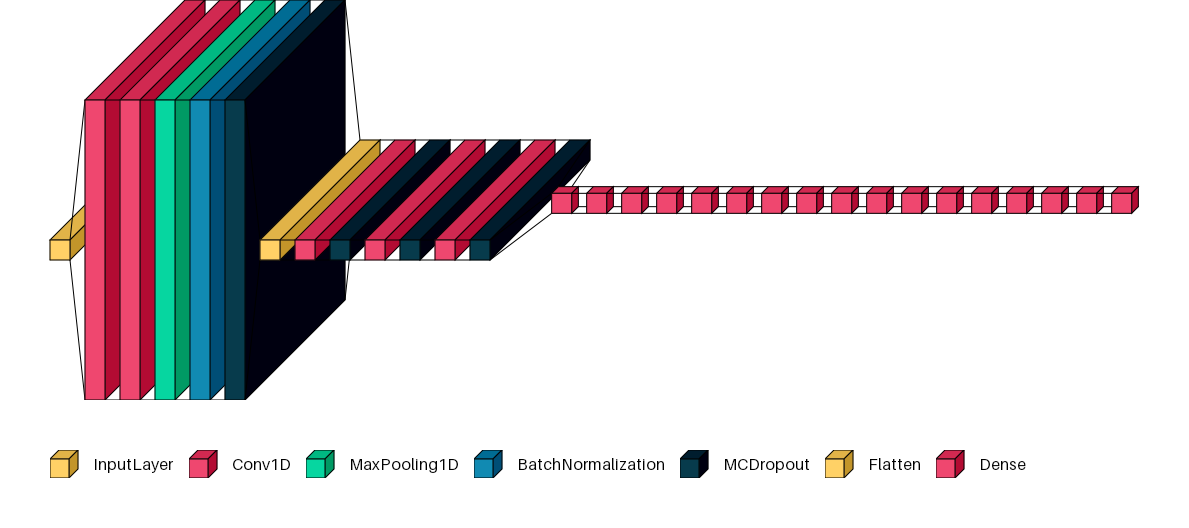

In [31]:
font = ImageFont.load_default(size = 16)

visualkeras.layered_view(cnn_tuner.best_model, to_file='../images/model_architecture.png', legend=True,
                        draw_funnel=True, draw_volume=True,
                        one_dim_orientation="x", max_xy=300, max_z=100, font=font, padding=50, spacing=15, shade_step=30)

In [23]:
#plot_model(cnn_tuner.best_model, to_file='../images/model.png', show_shapes=True, show_layer_names=True,  rankdir='TB', dpi=100)

# Stochastic predictions

In [27]:
num_samples = 1 

# Selecionar indices aleatórios
indices = np.random.choice(X_test_scaled.shape[0], size=num_samples, replace=False)

# Selecionar o subconjunto
X_test_subset = X_test_scaled[indices]
y_test_subset = y_test_scaled[indices]

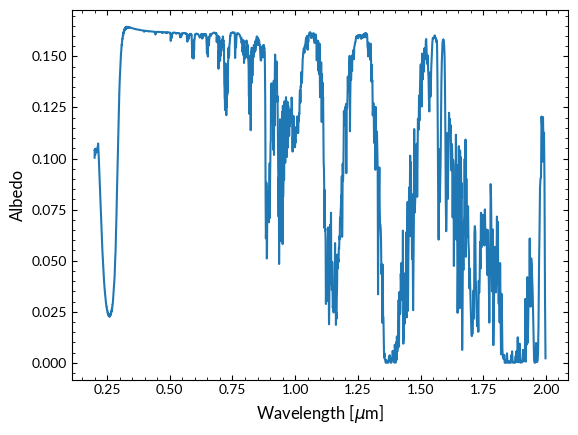

In [34]:
albedo_subset = scaler_X.inverse_transform(X_test_subset.reshape(1,-1)).reshape(2304,)
wv = dfabun["WAVELENGTH"][0]
plt.plot(wv, albedo_subset)
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Albedo");

In [35]:
# Número de iterações para Monte Carlo Dropout
n_iter = 1000

# Obter predições com incerteza para o subconjunto
predictions_array, mean_predictions, uncertainty = cnn_tuner.predict_with_uncertainty(X_test_subset, n_iter=n_iter)

In [36]:
predictions_inv_dict = {}

for idx, name in enumerate(cnn_tuner.outputs_list):
    preds = predictions_array[name]  # shape: (n_iter, num_samples, 1)
    preds_flat = preds.reshape(-1, 1)  # Flatten for inverse_transform
    preds_inv_flat = y_scalers[idx].inverse_transform(preds_flat)
    preds_inv = preds_inv_flat.reshape(preds.shape)  # Reshape back
    predictions_inv_dict[name] = preds_inv.squeeze(-1)  # Shape: (n_iter, num_samples)

predictions_combined = np.column_stack([predictions_inv_dict[name] for name in cnn_tuner.outputs_list])

y_test_dict = {name: y_test_subset[:, idx].reshape(-1, 1) for idx, name in enumerate(cnn_tuner.outputs_list)}
y_test_inv_dict = {}

for idx, name in enumerate(cnn_tuner.outputs_list):
    y_true_inv = y_scalers[idx].inverse_transform(y_test_dict[name])
    y_test_inv_dict[name] = y_true_inv.flatten()

y_test_combined = np.column_stack([
    np.tile(y_test_inv_dict[name], (n_iter, 1)).T.flatten()
    for name in cnn_tuner.outputs_list
])

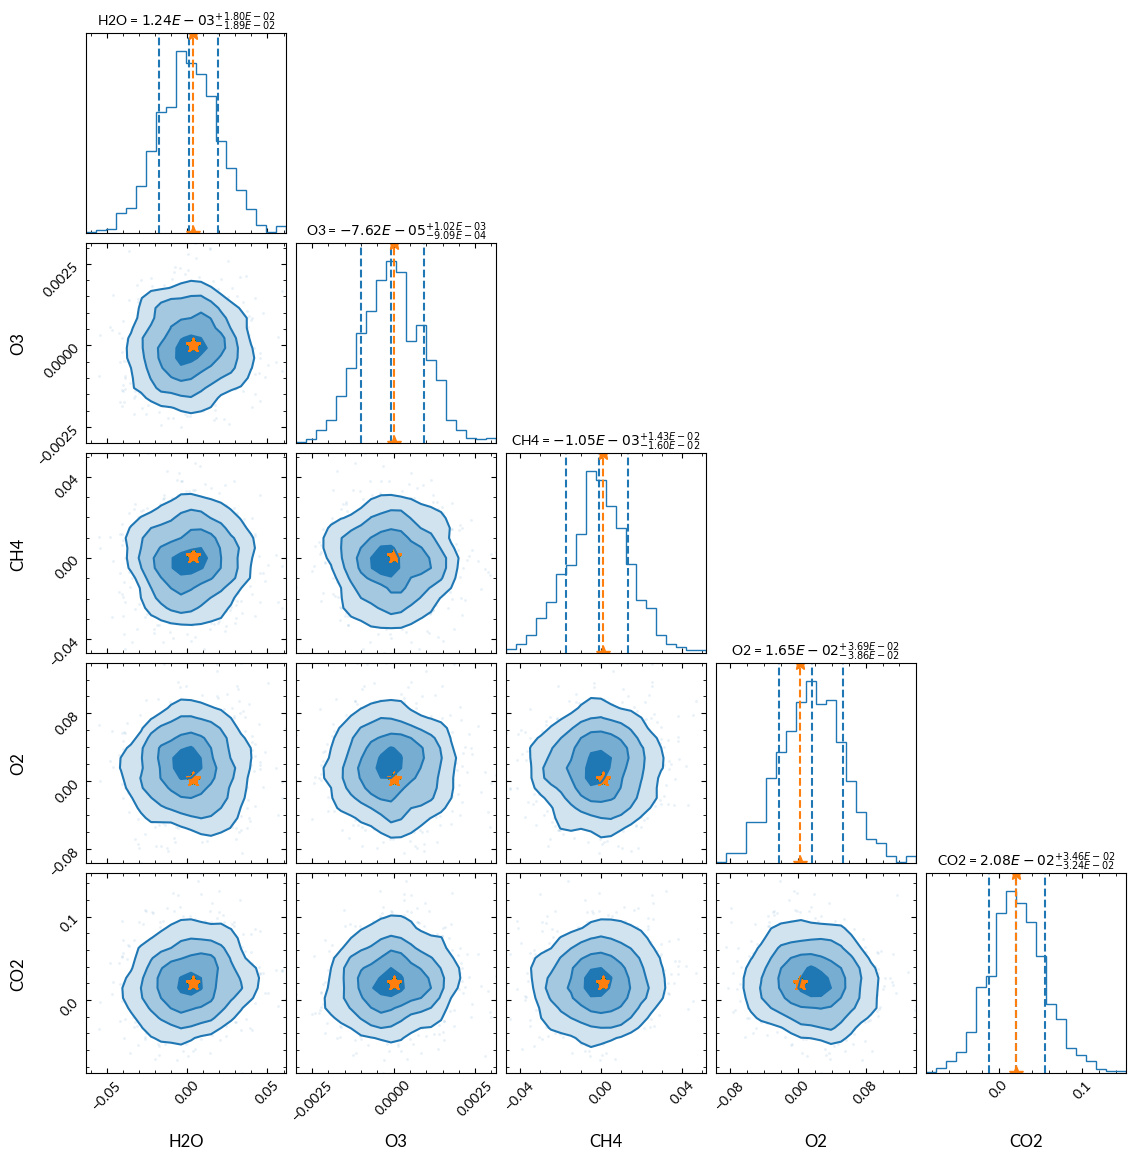

In [40]:
#abundances = ['C2H6', 'CH4', 'CO', 'CO2', 'H2', 'H2O', 'HCN', 'N2', 'N2O', 'NH3', 'O2', 'O3', 'PH3']
abundances = ["H2O", "O3", "CH4", "O2", "CO2"]
#abundances = ['OBJECT-DIAMETER', 'OBJECT-GRAVITY', 'ATMOSPHERE-PRESSURE', 'ATMOSPHERE-TEMPERATURE']
abundance_indices = [cnn_tuner.outputs_list.index(name) for name in abundances]

# Selecionar parâmetros a serem plotados (opcional)
# param_indices = list(range(17)) 
data_to_plot = predictions_combined[:, abundance_indices]
feature_names_selected = [cnn_tuner.outputs_list[i] for i in abundance_indices]
#feature_names_selected = ['DIAMETER', 'GRAVITY', 'PRESSURE', 'TEMPERATURE']

# Plotting the corner plot with only the abundances in blue color
figure = corner.corner(
    data_to_plot,
    labels=feature_names_selected,
    show_titles=True,
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    title_fmt=".2E",
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 12},
    max_n_ticks=3,
    smooth=0.9,
    color='tab:blue'
)

# True values (to be plotted as star points)
true_values_to_plot = y_test_combined[:, abundance_indices]

# Add the true values as stars to the corner plot
axes = np.array(figure.axes).reshape((len(abundance_indices), len(abundance_indices)))

# Loop over the diagonal and off-diagonal subplots to add true values
for i in range(len(abundance_indices)):
    for j in range(i + 1):
        ax = axes[i, j]
        if i == j:  # Diagonal plot (histogram)
            ax.axvline(true_values_to_plot[0, i], color='tab:orange', linestyle='--', marker='*', markersize=10)
        else:  # Off-diagonal plot (scatter)
            ax.scatter(true_values_to_plot[:, j], true_values_to_plot[:, i], color='tab:orange', marker='*', s=100)

plt.savefig('../images/cornerplot_abund.png')
plt.show()